In [1]:
import pandas as pd
import pathlib
from collections import Counter, OrderedDict
from difflib import SequenceMatcher as SM
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from pywaffle import Waffle

In [2]:
# Initialize directories
in_dir = pathlib.Path("./in/")
out_dir = pathlib.Path("./out/")
out_dir.mkdir(parents=True, exist_ok=True)

# Set seaborn style
sns.set(style="whitegrid")

In [14]:
def load_data():
    # Fetch papers
    df1 = pd.read_csv(in_dir / "initial_papers.csv")
    df1["source"] = "initial"
    df2 = pd.read_csv(in_dir / "snowball_papers.csv")
    df2["source"] = "snowball"
    df = pd.concat([df1, df2])
    df = df.reset_index(drop=True)

    # Filter out irrelevant papers
    df = df[(df["Relevant"] == "YES")]
    # Change columns' type
    df["Publication Year"] = df["Publication Year"].astype("int32")

    return df


df = load_data()

In [15]:
df

,Name,Author's affiliation,venue name,Item Type,Publication Year,Subject category,Data type,task,Abstract Note,Author,...,Q1.5,Q1.6,Q1.7,Q2,Q2.1,Q2.2,Replication package link,from,source,Read by
0,Automated Detection of Label Errors in Semanti...,Academia,IEEE/CVF Winter Conference on Applications of ...,journalArticle,2022,ML4DC,img,mislabel correction,"… labels at its boundary, which makes label er...","Rottmann, M; Reese, M",...,0.0,1.0,1.0,2,0.0,2.0,-,NaN,initial,NaN
1,Annotation Error Detection: Analyzing the Past...,Academia,Computational Linguistics,journalArticle,2022,"DC4ML, ML4DC",text,mislabel correction,"… Therefore, many automatic methods for annota...","Klie, JC; Webber, B; Gurevych, I",...,2.0,1.0,1.0,2,1.0,1.0,https://github.com/UKPLab/nessie,NaN,initial,NaN
2,READ: Aggregating Reconstruction Error into Ou...,Academia,AAAI,journalArticle,2022,NaN,NaN,outliers detection,Detecting out-of-distribution (OOD) samples is...,"Jiang, Wenyu; Cheng, Hao; Chen, Mingcai; Feng,...",...,1.0,2.0,2.0,2,0.0,2.0,https://github.com/lygjwy/READ,NaN,initial,NaN
4,Can Foundation Models Wrangle Your Data?,Both,arxiv,journalArticle,2022,ML4DC,tabular,more-than-one,"… As a proof-of-concept, we cast three data cl...","Narayan, A; Chami, I; Orr, L; Ré, C",...,2.0,2.0,2.0,4,2.0,2.0,https://github.com/HazyResearch/fm_data_tasks,NaN,initial,NaN
5,Sudowoodo: Contrastive Self-supervised Learnin...,Both,arxiv,journalArticle,2022,ML4DC,tabular,more-than-one,"… For data cleaning, we combine the error dete...","Wang, R; Li, Y; Wang, J",...,0.0,2.0,2.0,2,0.0,2.0,-,NaN,initial,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,Auto-EM: End-to-end Fuzzy Entity-Matching usin...,Both,ACM WWW,conferencePaper,2019,NaN,tabular,entity matching / duplicate removal,NaN,NaN,...,0.0,2.0,2.0,2,0.0,2.0,https://github.com/henryzhao5852/AutoEM,NaN,snowball,PO
194,Entity Matching with Transformer Architectures...,Academia,International Conference on Extending Database...,conferencePaper,2020,NaN,tabular,entity matching / duplicate removal,NaN,NaN,...,2.0,1.0,1.0,2,0.0,2.0,https://github.com/brunnurs/entity-matching-tr...,NaN,snowball,PO
195,Hierarchical matching network for heterogeneou...,Academia,IJCAI,conferencePaper,2021,NaN,tabular,entity matching / duplicate removal,NaN,NaN,...,0.0,2.0,2.0,2,0.0,2.0,NaN,NaN,snowball,PO
196,Generative Adversarial Active Learning for Uns...,Academia,IEEE Trans. Knowl. Data Eng.,journalArticle,2019,ML4DC,tabular,outliers detection,Outlier detection is an important topic in mac...,https://ieeexplore.ieee.org/author/37577989000...,...,0.0,2.0,2.0,2,0.0,2.0,https://github.com/leibinghe/GAAL-based-outlie...,NaN,snowball,NaN


### Conferences

In [16]:
def detect_potential_duplicates_venue_name():
    venue_names = df["venue name"].unique()
    potential_duplicates = []
    for i in range(len(venue_names)):
        for j in range(i + 1, len(venue_names)):
            ratio = SM(None, venue_names[i], venue_names[j]).ratio()
            if ratio > 0.75:
                potential_duplicates.append((venue_names[i], venue_names[j]))
    return potential_duplicates


# potential_duplicates = detect_potential_duplicates_venue_name()
# potential_duplicates

In [17]:
def get_venue_most_than_one():
    """
    Returns the venues that more than one paper cited.
    """
    cnt = Counter(df["venue name"]).most_common()
    d = OrderedDict()
    for k, v in cnt:
        if v > 1:
            d[k] = v
    return d


d = get_venue_most_than_one()

In [18]:
d

OrderedDict([('arxiv', 19),
             ('ACM SIGMOD', 8),
             ('AAAI', 4),
             ('Expert Syst. Appl.', 3),
             ('VLDB Endowment', 3),
             ('VLDB Journal', 2),
             ('IEEE ICDE', 2),
             ('IJCAI', 2),
             ('NeurIPS', 2),
             ('Procedia Comput. Sci.', 2),
             ('proquest', 2),
             ('ACM CIKM', 2),
             ('ICASSP', 2),
             ('ACM WWW', 2),
             ('IEEE Trans. Knowl. Data Eng.', 2),
             ('Pattern Recognit.', 2),
             ('IEEE/CVF CVPR', 2)])

In [19]:
df[df["venue name"] == "VLDB Endowment"]

,Name,Author's affiliation,venue name,Item Type,Publication Year,Subject category,Data type,task,Abstract Note,Author,...,Q1.5,Q1.6,Q1.7,Q2,Q2.1,Q2.2,Replication package link,from,source,Read by
131,Cleaning Crowdsourced Labels Using Oracles For...,Academia,VLDB Endowment,conferencePaper,2018,ML4DC,tabular,mislabel correction,… supervised learning algorithm for noisy labe...,"Dolatshah, M; Teoh, M; Wang, J; Pei, J",...,0.0,1.0,1.0,2,2.0,0.0,NaN,NaN,initial,NaN
171,Distributed representations of tuples for enti...,Academia,VLDB Endowment,conferencePaper,2018,ML4DC,tabular,entity matching / duplicate removal,NaN,"M. Ebraheem, S. Thirumuruganathan, S. Joty, M....",...,0.0,2.0,2.0,2,0.0,2.0,-,CleanML: A study for evaluating the impact of ...,snowball,NaN
172,Baran: Effective Error Correction via a Unifie...,Academia,VLDB Endowment,conferencePaper,2020,ML4DC,tabular,error repair,NaN,NaN,...,0.0,2.0,2.0,4,2.0,2.0,https://github.com/bigdama/raha,Semi-Supervised Data Cleaning with Raha and Ba...,snowball,PO


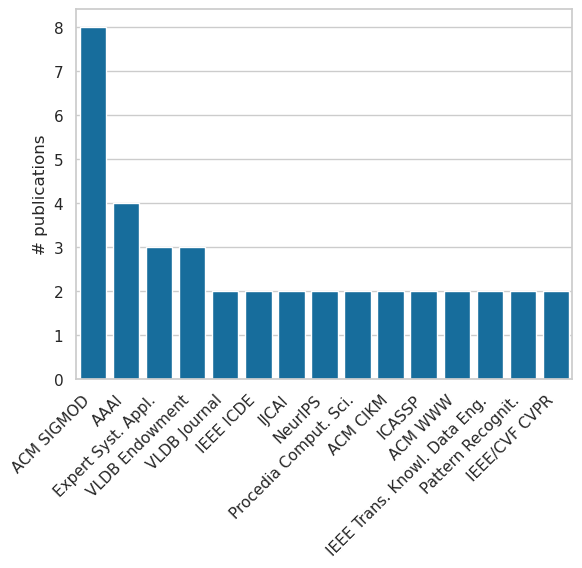

In [20]:
def plot_n_papers_venues(d, file_name="venues"):
    d_copy = deepcopy(d)
    del d_copy["arxiv"]
    del d_copy["proquest"]
    ax = sns.barplot(
        x=list(d_copy.keys()),
        y=list(d_copy.values()),
        color=sns.color_palette("colorblind")[0],
    )
    ax.set_ylabel("# publications")

    # ax.set_axisbelow(True)
    # ax.grid(axis='y')

    plt.xticks(rotation=45, ha="right")
    if file_name:
        plt.savefig(out_dir / f"{file_name}.pdf", bbox_inches="tight")


plot_n_papers_venues(d)

### Number of papers per year


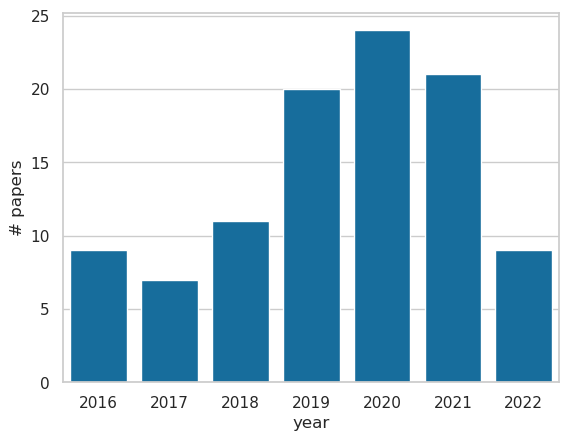

In [21]:
def plot_papers_per_year(df, file_name="years"):
    ax = sns.countplot(
        data=df, x="Publication Year", color=sns.color_palette("colorblind")[0]
    )
    ax.set_ylabel("# papers")
    ax.set_xlabel("year")

    if file_name:
        plt.savefig(out_dir / f"{file_name}.pdf", bbox_inches="tight")


plot_papers_per_year(df)

### Authors' affiliation 

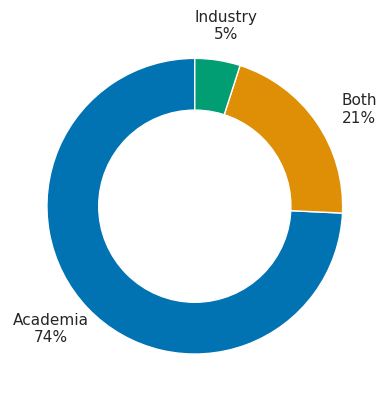

In [22]:
def plot_authors_affiliation(df, file_name="affiliation"):
    cnt = Counter(df["Author's affiliation"])
    keys, values = list(cnt.keys()), list(cnt.values())
    # Count percentages
    tot = sum(values)
    keys = [f"{key}\n{(value/tot)*100:.0f}%" for key, value in zip(keys, values)]

    # plot
    _, labels = plt.pie(
        values,
        labels=keys,
        colors=sns.color_palette("colorblind"),
        startangle=90,
        labeldistance=1.35,
    )

    # Change labels horizontal and vertical alignement
    for i, label in enumerate(labels):
        label.set_horizontalalignment("center")
        if i == 0:
            label.set_verticalalignment("bottom")
        else:
            label.set_verticalalignment("top")

    # add a circle at the center to transform it in a donut chart
    my_circle = plt.Circle((0, 0), 0.65, color="white")
    p = plt.gcf()
    p.gca().add_artist(my_circle)

    if file_name:
        plt.savefig(out_dir / f"{file_name}.pdf", bbox_inches="tight")


plot_authors_affiliation(df)

### Per cleaning activity

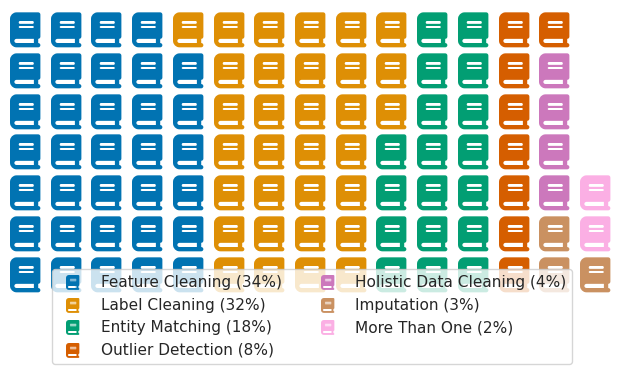

In [23]:
def generate_waffle_plot(df, col_name, file_name=None):
    cnt = OrderedDict(Counter(df[col_name].dropna().tolist()).most_common())
    tot = sum(cnt.values())
    val = [100 * (x / tot) for x in cnt.values()]
    labels = [f'{x} ({"{:.0f}".format(val[i])}%)' for i, x in enumerate(cnt.keys())]

    fig = plt.figure(
        FigureClass=Waffle,
        columns=15,
        values=cnt,
        labels=labels,
        colors=sns.color_palette("colorblind")[: len(cnt)],
        legend={
            "loc": "lower center",
            "bbox_to_anchor": (0.5, -0.3),
            "fontsize": 11,
            "ncol": 2,
        },
        icons="book",
        font_size=25,
        icon_legend=True,
        block_arranging_style="snake"
        # figsize=(6, 6),
    )

    if file_name:
        plt.savefig(out_dir / f"{file_name}.pdf", bbox_inches="tight")


def plot_cleaning_activity(df, file_name="task"):
    # Preprocess data
    df_c = df.copy()
    df_c.loc[df["task"] == "error detection/repair", "task"] = "Feature Cleaning"
    df_c.loc[df_c["task"] == "error detection", "task"] = "Feature Cleaning"
    df_c.loc[df_c["task"] == "error repair", "task"] = "Feature Cleaning"
    df_c.loc[df_c["task"] == "mislabel correction", "task"] = "Label Cleaning"
    df_c.loc[
        df_c["task"] == "entity matching / duplicate removal", "task"
    ] = "Entity Matching"
    df_c.loc[df_c["task"] == "outliers detection", "task"] = "Outlier Detection"
    df_c.loc[df_c["task"] == "imputation", "task"] = "Imputation"
    df_c.loc[df_c["task"] == "more-than-one", "task"] = "More Than One"
    df_c.loc[df_c["task"] == "holistic", "task"] = "Holistic Data Cleaning"

    generate_waffle_plot(df_c, "task", file_name)


plot_cleaning_activity(df)

In [24]:
df_c = df.copy()
df_c.loc[df_c["task"] == "error detection/repair", "task"] = "Feature Cleaning"
df_c.loc[df_c["task"] == "error detection", "task"] = "Feature Cleaning"
df_c.loc[df_c["task"] == "error repair", "task"] = "Feature Cleaning"
df_c.loc[df_c["task"] == "mislabel correction", "task"] = "Label Cleaning"
df_c.loc[
    df_c["task"] == "entity matching / duplicate removal", "task"
] = "Entity Matching"
df_c.loc[df_c["task"] == "outliers detection", "task"] = "Outlier Detection"
df_c.loc[df_c["task"] == "imputation", "task"] = "Imputation"
df_c.loc[df_c["task"] == "more-than-one", "task"] = "Combined"

df_c[df_c["task"] == "Combined"]

,Name,Author's affiliation,venue name,Item Type,Publication Year,Subject category,Data type,task,Abstract Note,Author,...,Q1.5,Q1.6,Q1.7,Q2,Q2.1,Q2.2,Replication package link,from,source,Read by
4,Can Foundation Models Wrangle Your Data?,Both,arxiv,journalArticle,2022,ML4DC,tabular,Combined,"… As a proof-of-concept, we cast three data cl...","Narayan, A; Chami, I; Orr, L; Ré, C",...,2.0,2.0,2.0,4,2.0,2.0,https://github.com/HazyResearch/fm_data_tasks,NaN,initial,NaN
5,Sudowoodo: Contrastive Self-supervised Learnin...,Both,arxiv,journalArticle,2022,ML4DC,tabular,Combined,"… For data cleaning, we combine the error dete...","Wang, R; Li, Y; Wang, J",...,0.0,2.0,2.0,2,0.0,2.0,-,NaN,initial,NaN


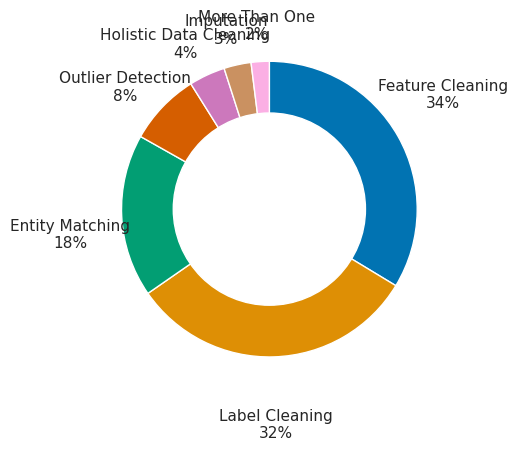

In [31]:
def plot_cleaning_activity_v2(df, file_name="affiliation"):
    # Preprocess data
    df = df.copy()
    df.loc[df["task"] == "error detection/repair", "task"] = "Feature Cleaning"
    df.loc[df["task"] == "error detection", "task"] = "Feature Cleaning"
    df.loc[df["task"] == "error repair", "task"] = "Feature Cleaning"
    df.loc[df["task"] == "mislabel correction", "task"] = "Label Cleaning"
    df.loc[
        df["task"] == "entity matching / duplicate removal", "task"
    ] = "Entity Matching"
    df.loc[df["task"] == "outliers detection", "task"] = "Outlier Detection"
    df.loc[df["task"] == "imputation", "task"] = "Imputation"
    df.loc[df["task"] == "more-than-one", "task"] = "More Than One"
    df.loc[df["task"] == "holistic", "task"] = "Holistic Data Cleaning"
    cnt = Counter(df["task"]).most_common()
    keys, values = [x[0] for x in cnt], [x[1] for x in cnt]
    # Count percentages
    tot = sum(values)
    keys = [f"{key}\n{(value/tot)*100:.0f}%" for key, value in zip(keys, values)]

    # plot
    _, labels = plt.pie(
        values,
        labels=keys,
        colors=sns.color_palette("colorblind"),
        startangle=90,
        labeldistance=1.35,
        counterclock=False,
    )

    # Change labels horizontal and vertical alignement
    for i, label in enumerate(labels):
        label.set_horizontalalignment("center")
        if i == 0:
            label.set_verticalalignment("bottom")
        else:
            label.set_verticalalignment("top")

    # add a circle at the center to transform it in a donut chart
    my_circle = plt.Circle((0, 0), 0.65, color="white")
    p = plt.gcf()
    p.gca().add_artist(my_circle)

    if file_name:
        plt.savefig(out_dir / f"{file_name}.pdf", bbox_inches="tight")


plot_cleaning_activity_v2(df)